In [2]:
import random as rd
import numpy as np
import time
import matplotlib.pyplot as plt
from scipy.stats import expon
import math
import simpy
# import numpy.random
from collections import deque
from numpy import random
import heapq
from dataclasses import dataclass

In [148]:
class TimeDependentQueue(object):
    def __init__(self,num_servers, mu, max_time):
        self.num_servers = num_servers
        self.mu = mu
        self.max_time = max_time
        self.time_steps = range(max_time)
        self.queue_length_over_time = np.zeros(max_time)
        self.num_in_queue = 0
        self.current_time = 0
        self.arrivals = []
        self.departures = []

    def time_dependent_lambda(self, t):
        half_time = self.max_time / 2
        # se está nas primeiras 1/4 de horas, lambda =1
        if t < self.max_time/4 or t > 3*self.max_time/4:
            return 1
        # se está depois lambda é uma parábola
        else:
            a = (1 - 6) / (half_time)**1.8
            b = 5

            return a * (t - half_time)**2 + b
        #return 0.5 + 0.4 * math.sin(math.pi * t / 60)
    
    def run(self):
        while self.current_time < self.max_time:
            # Determinar a próxima chegada
            lambda_current = self.time_dependent_lambda(self.current_time)
            next_arrival = self.current_time + np.random.exponential(scale=1/lambda_current)

            # Determinar a próxima saída
            if self.num_in_queue > 0:
                next_departure = self.current_time + np.random.exponential(scale=1/(self.mu * min(self.num_in_queue, self.num_servers)))
            else:
                next_departure = float('inf')

            # Atualizar o estado do sistema e registrar eventos
            if next_arrival < next_departure:
                # O próximo evento é uma chegada
                self.current_time = min(next_arrival, self.max_time)
                self.num_in_queue += 1
                self.arrivals.append(self.current_time)
            else:
                # O próximo evento é uma saída
                self.current_time = min(next_departure, self.max_time)
                self.num_in_queue = max(self.num_in_queue - 1, 0)
                if self.arrivals:
                    self.departures.append(self.current_time)

            # Registrar o comprimento da fila a cada minuto
            for t in range(int(self.current_time), self.max_time):
                self.queue_length_over_time[t] = self.num_in_queue

        plt.figure(figsize=(12,4))
        # Plotar o comprimento da fila ao longo do tempo
        plt.plot(self.time_steps, self.queue_length_over_time, label='Comprimento da Fila')
        # plot line in x = 90
        plt.axvline(x=90, color='r', linestyle='--')
        # plot line in x = 270
        plt.axvline(x=270, color='r', linestyle='--')
        plt.xticks(np.arange(0, self.max_time + 30, step=30))
        plt.xlabel('Tempo (minutos)')
        plt.ylabel('Comprimento da fila')
        plt.title('Simulação de Fila Dependente do Tempo (M/M/3)')
        plt.legend()
        plt.grid(True)
        plt.show()

        wait_times = [d - a for a, d in zip(self.arrivals, self.departures)]

        # Calculate mean waiting times in specified intervals
        mean_wait_0_120 = np.mean([w for a, w in zip(self.arrivals, wait_times) if 0 <= a < 90])
        mean_wait_120_180 = np.mean([w for a, w in zip(self.arrivals, wait_times) if 90 <= a < 270])
        mean_wait_180_300 = np.mean([w for a, w in zip(self.arrivals, wait_times) if 270 <= a < 360])

        print(f'Tempo médio de espera do primeiro quartil: {mean_wait_0_120}')
        print(f'Tempo médio de espera do segundo quartil: {mean_wait_120_180}')
        print(f'Tempo médio de espera do quarto quartil: {mean_wait_180_300}')

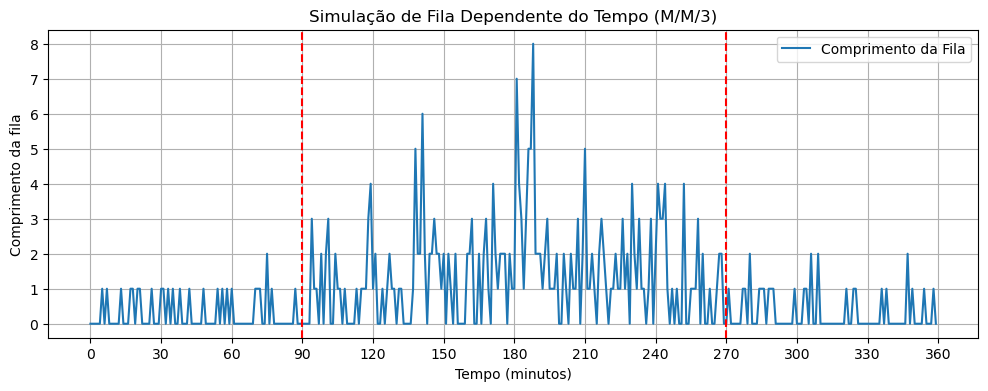

Tempo médio de espera do primeiro quartil: 0.33240394542210194
Tempo médio de espera do segundo quartil: 0.3795127215711598
Tempo médio de espera do quarto quartil: 0.3097241618616922


In [154]:
# Parâmetros da simulação
mu = 3.0  # taxa de serviço constante (por exemplo, 1 cliente por minuto)
servers = 3  # número de servidores
max_time = 360  # tempo total de simulação em minutos

queue = TimeDependentQueue(servers, mu, max_time)
queue.run()

### Priority Queue

In [268]:
class Mm2PriorityQueue:
    def __init__(self, high_priority_arrival_rate, low_priority_arrival_rate, service_rate, max_time):
        self.high_priority_arrival_rate = high_priority_arrival_rate
        self.low_priority_arrival_rate = low_priority_arrival_rate
        self.service_rate = service_rate
        self.max_time = max_time
        self.high_priority_queue = []
        self.low_priority_queue = []
        self.current_time = 0
        self.server_busy = [False, False]  # Two servers
        self.events = []  # List to store events for visualization
        self.arrival_times = {'high': [], 'low': []}
        self.start_times = {'high': [], 'low': []}
        self.waiting_times = {'high': [], 'low': []}

    def run(self):
        while self.current_time < self.max_time:
            # Determine the next arrival for high and low priority customers
            next_high_priority_arrival = self.current_time + expon.rvs(scale=1/self.high_priority_arrival_rate)
            next_low_priority_arrival = self.current_time + expon.rvs(scale=1/self.low_priority_arrival_rate)

            # Determine the next departure time for each server
            next_departures = [self.current_time + expon.rvs(scale=1/self.service_rate) if self.server_busy[i] else float('inf') for i in range(2)]

            # Find the next event (arrival or departure)
            next_event_time = min(next_high_priority_arrival, next_low_priority_arrival, min(next_departures))
            event_type = 'arrival' if next_event_time in [next_high_priority_arrival, next_low_priority_arrival] else 'departure'

            # Update current time
            self.current_time = next_event_time

            # Handle the event
            if event_type == 'arrival':
                if next_event_time == next_high_priority_arrival:
                    self.high_priority_queue.append(self.current_time)
                    priority = 'high'
                    self.arrival_times[priority].append(self.current_time)
                else:
                    self.low_priority_queue.append(self.current_time)
                    priority = 'low'
                self.events.append((self.current_time, priority, 'arrival'))
            else:
                # Find which server is departing
                departing_server = next_departures.index(next_event_time)
                self.server_busy[departing_server] = False
                self.events.append((self.current_time, 'server ' + str(departing_server), 'departure'))
                if priority == 'high' and self.high_priority_queue:
                    start_time = self.current_time
                    arrival_time = self.high_priority_queue.pop(0)
                    self.start_times[priority].append(start_time)
                    self.waiting_times[priority].append(start_time - arrival_time)
                elif priority == 'low' and self.low_priority_queue:
                    start_time = self.current_time
                    arrival_time = self.low_priority_queue.pop(0)
                    self.start_times[priority].append(start_time)
                    self.waiting_times[priority].append(start_time - arrival_time)

            # Assign servers to waiting customers, with priority given to high priority customers
            for i in range(2):
                if not self.server_busy[i]:
                    if self.high_priority_queue:
                        self.high_priority_queue.pop(0)
                        self.server_busy[i] = True
                    elif self.low_priority_queue:
                        self.low_priority_queue.pop(0)
                        self.server_busy[i] = True

    def plot_events(self):
        times, labels, types = zip(*self.events)
        colors = {'high': 'red', 'low': 'blue', 'server 0': 'green', 'server 1': 'orange'}
        plt.scatter(times, labels, c=[colors[label] for label in labels], label=types)
        plt.xlabel('Time')
        plt.ylabel('Events')
        plt.title('M/M/2 Priority Queue Events Simulation')
        plt.show()

    def plot_waiting_times(self):
        # Plot histograms of waiting times for high and low priority customers
        plt.hist(self.waiting_times['high'], bins=30, alpha=0.5, label='High Priority')
        plt.hist(self.waiting_times['low'], bins=30, alpha=0.5, label='Low Priority')
        plt.xlabel('Tempo de Espera (minutos)')
        plt.ylabel('Número de Clientes')
        plt.title('Distribuição do Tempo de Espera')
        plt.legend()
        plt.show()

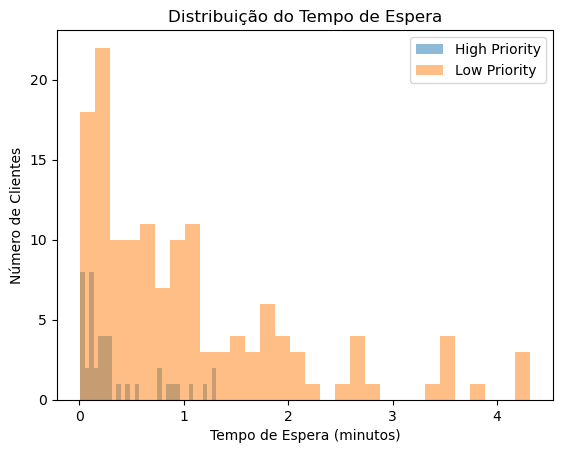

In [271]:
high_priority_arrival_rate = 0.6  # High priority customer arrival rate
low_priority_arrival_rate = 1.2   # Low priority customer arrival rate
service_rate = 1.0                # Service rate
max_time = 10                    # Simulation time

queue_sim = Mm2PriorityQueue(high_priority_arrival_rate, low_priority_arrival_rate, service_rate, max_time)
queue_sim.run()
queue_sim.plot_waiting_times()

### Retrial Queue

É quando um cliente que não foi atendido retorna para a fila. Por exemplo, um cliente que não foi atendido em um banco pode voltar para a fila no dia seguinte. Ou um cliente que não foi atendido em um call center pode ligar novamente mais tarde. Ou um cliente que não foi atendido em um site de comércio eletrônico pode voltar mais tarde para tentar novamente, etc. Quando isso acontece, dizemos que o cliente está em órbita.

- Clientes em órbita não sabem o estado das filas e apenas saberão se a fila está vazia ou não quando chegarem ao servidor. 
- Clientes entram e saem da órbita até serem atendidos ou desistirem. 

In [324]:
@dataclass(order=True)
class Event:
    time: float
    client_id: int

class RetrialQueueMM1:
    """
    Simulação de fila M/M/1 com retrials:
    * Clientes chegam na fila com taxa exponencial lambda.
    * O tempo de serviço é exponencial com taxa mu.
    * Qualquer cliente, ao encontrar o servidor ocupado, se torna um cliente retrial (em órbita)
    e passa um tempo de retrial exponencial com taxa gamma até tentar novamente.
    * Clientes tentarão novamente até serem atendidos (caso sem desistências).
    * Os interarrival times e os tempos de serviço são independentes.

    Parâmetros
    ----------
    lambda_ : float
        Taxa de chegada de clientes.
    mu : float
        Taxa de atendimento de clientes.
    gamma : float
        Taxa de retrial de clientes.
    max_time : float
        Tempo máximo de simulação.
    seed : int, opcional
        Semente para o gerador de números aleatórios.
    """
    def __init__(
        self, lambda_: float, mu: float, gamma: float, max_time: float, seed: int | None = None
    ) -> None:
        self.lambda_ = lambda_
        self.mu = mu
        self.gamma = gamma
        self.max_time = max_time
        self.rng = np.random.default_rng(seed)

        self.latest_client_id = 0
        self.service_end_time = 0.0
        self.services: list[Event] = []
        self.queue: list[Event] = [Event(self.rng.exponential(1 / self.lambda_), 0)]
        self.arrivals: list[Event] = [self.queue[0]]

    def new_arrival(self, base: Event, retrial: bool = True) -> None:
        """Cria um novo evento de chegada tendo como base um evento anterior."""
        if retrial:
            event = Event(base.time + self.rng.exponential(1 / self.gamma), base.client_id)
        else:
            event = Event(base.time + self.rng.exponential(1 / self.lambda_), base.client_id + 1)
            self.latest_client_id = event.client_id

        heapq.heappush(self.queue, event)
        # Registra no histórico de chegadas
        self.arrivals.append(event)

    def new_service(self, base: Event) -> None:
        """Cria um novo evento de serviço tendo como base um evento anterior."""
        self.services.append(base)
        self.service_end_time = base.time + self.rng.exponential(1 / self.mu)
        self.services.append(Event(self.service_end_time, base.client_id))

    def new_if_latest_client(self, base: Event) -> None:
        """Se o ID do cliente é o mais recente, atualiza o cliente mais recente."""
        if base.client_id == self.latest_client_id:
            self.new_arrival(base, retrial=False)

    def run(self) -> None:
        while True:
            # Processa todos os eventos que ocorrem até o fim do serviço atual
            while self.queue[0].time < self.service_end_time:
                earliest = heapq.heappop(self.queue)
                self.new_if_latest_client(earliest)

                # Cliente atual volta mais tarde
                self.new_arrival(earliest, retrial=True)

            next_ = heapq.heappop(self.queue)
            # Encerra se o começo de um atendimento seria depois do tempo máximo
            if next_.time > self.max_time:
                break
            self.new_if_latest_client(next_)
            self.new_service(next_)

    def plot_orbit(self):
        times = []
        orbit = []
        num_in_orbit = 0

        all_events = sorted(self.arrivals + self.services, key=lambda e: e.time)
        for event in all_events:
            if event in self.arrivals:
                num_in_orbit += 1
            elif event in self.services:
                num_in_orbit -= 1
            times.append(event.time)
            orbit.append(num_in_orbit)

        plt.plot(times, orbit)
        plt.xlabel('Time')
        plt.ylabel('Number of people in orbit')
        plt.title('Number of people in orbit over time')
        plt.show()
                

In [446]:
lambda_ = 0.7
mu = 1.8  # taxa de serviço
gamma = 2
max_time = 180  # tempo total de simulação em minutos
time_steps = range(max_time)

retrial = RetrialQueueMM1(lambda_, mu, gamma, max_time=max_time, seed=42)
retrial.run()

n_clients = max(retrial.arrivals, key=lambda x: x.client_id).client_id + 1

In [447]:
n_clients

121

In [448]:
i = 0
for event in sorted(retrial.arrivals):
    print("Cliente", event.client_id, "olhou para a fila em", event.time)
    if i < len(retrial.services) and event == retrial.services[i]:
        print("Fim de atendimento de cliente", event.client_id, "em", retrial.services[i + 1].time)
        i += 2

Cliente 0 olhou para a fila em 3.434583719951421
Fim de atendimento de cliente 0 em 4.7594509421037845
Cliente 1 olhou para a fila em 6.771997513986355
Fim de atendimento de cliente 1 em 6.820018291596564
Cliente 2 olhou para a fila em 7.17170364234576
Fim de atendimento de cliente 2 em 7.955015139155523
Cliente 3 olhou para a fila em 9.246932950497403
Fim de atendimento de cliente 3 em 9.29098528226602
Cliente 4 olhou para a fila em 13.710212888425257
Fim de atendimento de cliente 4 em 13.749344169979596
Cliente 5 olhou para a fila em 15.20529981205835
Fim de atendimento de cliente 5 em 16.167148341438242
Cliente 6 olhou para a fila em 16.761047852092577
Fim de atendimento de cliente 6 em 17.445262109126784
Cliente 7 olhou para a fila em 17.31375474436388
Cliente 7 olhou para a fila em 17.359543378058977
Cliente 7 olhou para a fila em 17.517132979125172
Fim de atendimento de cliente 7 em 18.017799243219706
Cliente 8 olhou para a fila em 17.53343082125849
Cliente 9 olhou para a fila em

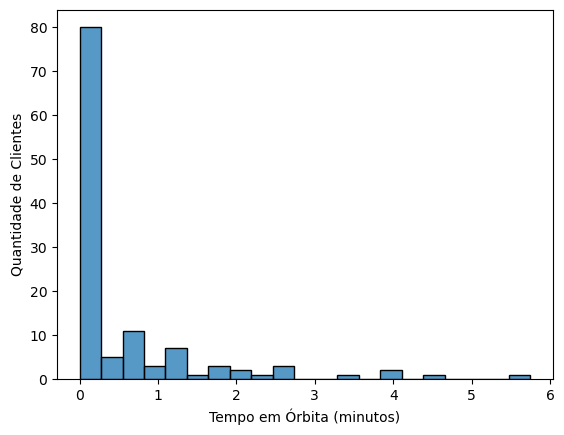

In [451]:
def division(a, b):
    return a / b if b else 0

# Função para permitir a divisão por 0
division = np.vectorize(division, otypes=[float])

wait_counts = np.zeros(n_clients, dtype=int)
first_arrivals = np.zeros(n_clients)
wait_times = np.zeros(n_clients)

for arrival in retrial.arrivals:
    first = first_arrivals[arrival.client_id]
    # Se a primeira chegada ainda não foi registrada, ela é ignorada
    if first == 0.0:
        first_arrivals[arrival.client_id] = arrival.time
        continue
    wait_counts[arrival.client_id] += 1
    # Tempo total de espera
    wait_times[arrival.client_id] = arrival.time - first

# Tempo de retrial de cada cliente
wait_times
# Média de tempo de retrial de cada cliente
division(wait_times, wait_counts)

import matplotlib.pyplot as plt
import seaborn

seaborn.histplot(wait_times)
plt.xlabel("Tempo em Órbita (minutos)")
plt.ylabel("Quantidade de Clientes")
plt.show()